# 1. Analyse Exploratoire et Préparation des Données - Chicago Taxi Trips

Ce notebook combine l'analyse exploratoire du dataset Chicago Taxi Trips et la préparation des données pour le forecasting. Nous allons :
- Explorer la structure et la qualité des données
- Analyser les distributions et tendances temporelles
- Préparer les données agrégées pour le forecasting par heure et par zone
- Enrichir le dataset avec des features temporelles
- Exporter les données vers BigQuery pour l'utilisation avec Vertex AI Forecast

## 1.1 Configuration et Imports

Importons les bibliothèques nécessaires et initialisons la connexion à BigQuery.

In [1]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # pour visualiser les valeurs manquantes
import yaml
import os
from datetime import datetime, timedelta
from google.cloud import bigquery
import db_dtypes  # Pour les types de données spécifiques à BigQuery

# Pour BigQuery
from pandas_gbq import read_gbq

# Configuration visuelle
%matplotlib inline
sns.set(style="whitegrid", context="talk")  # style épuré et taille adaptée aux présentations
base_palette = sns.color_palette("viridis", 8)
sns.set_palette(base_palette)

# Supprimer les warnings pour une sortie plus propre
import warnings
warnings.filterwarnings('ignore')

## 1.2 Configuration du Projet

Définissons les identifiants du projet GCP et les paramètres généraux.

In [2]:
# Configuration du projet GCP
PROJECT_ID = "avisia-certification-ml-yde"  # Remplacez par votre Project ID
REGION = "europe-west1"
BQ_DATASET = "chicago_taxis"

# Chargement de la configuration YAML si disponible
try:
    with open("../config/pipeline_config.yaml", "r") as f:
        config = yaml.safe_load(f)
    print("Configuration chargée avec succès depuis pipeline_config.yaml")
except Exception as e:
    print(f"Impossible de charger le fichier de configuration: {e}")
    config = {}

# Initialisation du client BigQuery
client = bigquery.Client(project=PROJECT_ID)

Configuration chargée avec succès depuis pipeline_config.yaml


# 2. Analyse Exploratoire des Données

Explorons le dataset Chicago Taxi Trips pour comprendre sa structure et identifier les patterns.

## 2.1 Chargement d'un Échantillon pour Exploration

Commençons par charger un échantillon limité pour l'exploration initiale.

In [3]:
# Définition de la requête SQL pour récupérer un échantillon depuis BigQuery
sample_query = """
SELECT *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_start_timestamp BETWEEN '2023-01-01' AND '2023-01-07'
LIMIT 100000
"""

# Chargement du dataset depuis BigQuery
try:
    df_sample = pd.read_gbq(sample_query, project_id=PROJECT_ID)
    print("Dataset d'échantillon chargé avec succès depuis BigQuery.")
except Exception as e:
    print(f"Erreur lors du chargement depuis BigQuery: {e}")
    exit()

# Nettoyage initial des noms de colonnes
df_sample.columns = df_sample.columns.str.strip().str.lower().str.replace(' ', '_')
print("\nNoms des colonnes après nettoyage :")
print(df_sample.columns)

# Aperçu des données
print("\nAperçu des données (5 premières lignes) :")
df_sample.head()

Dataset d'échantillon chargé avec succès depuis BigQuery.

Noms des colonnes après nettoyage :
Index(['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location'],
      dtype='object')

Aperçu des données (5 premières lignes) :


,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,1e539d6e7501164c6b76b761c3152c235e206d59,4ab7a7510c1ebcc9b2e3eaa7bdd6508dbea34da7986aca...,2023-01-01 00:00:00+00:00,2023-01-01 00:15:00+00:00,1341,16.63,<NA>,<NA>,76,8,...,6.0,53.00,Credit Card,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
1,0fca59218b11688279d795c03c4d16f851f13fa0,e2c349c7cbb608d552aa0b5814031943f13641ef9e50d8...,2023-01-01 00:00:00+00:00,2023-01-01 00:15:00+00:00,1037,4.82,<NA>,<NA>,6,32,...,0.0,19.50,Credit Card,Taxicab Insurance Agency Llc,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
2,2b3c5200439d51f626b60380809bbbcca766a85b,8c76eb82f069c0731a0049cb78898f02cc5ac6990244c9...,2023-01-01 00:00:00+00:00,2023-01-01 00:15:00+00:00,844,3.84,<NA>,<NA>,24,8,...,0.0,20.17,Mobile,Sun Taxi,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,728d5dfa01d3fa5fbb3cf3a7e7e53d1f898f9562,2d96913fe577ab280429b9b477b75f74ea2e987fabfdfd...,2023-01-04 13:30:00+00:00,2023-01-04 13:30:00+00:00,22,0.00,<NA>,<NA>,<NA>,<NA>,...,0.0,3.25,Cash,Flash Cab,NaN,NaN,None,NaN,NaN,None
4,72fea6810c3a22f2137a6a8b8ad10db48f2cc600,a874c3831c6a3a67f9491242adda2031c9d25888ddab68...,2023-01-05 13:15:00+00:00,2023-01-05 13:45:00+00:00,1707,18.10,<NA>,<NA>,<NA>,<NA>,...,4.0,58.50,Credit Card,City Service,NaN,NaN,None,NaN,NaN,None


## 2.2 Comprendre les Données

Analysons la structure et les statistiques descriptives des données.

In [4]:
# Conversion des types de données
# Timestamps
for col in ['trip_start_timestamp', 'trip_end_timestamp']:
    if col in df_sample.columns:
        df_sample[col] = pd.to_datetime(df_sample[col], errors='coerce')

# Numériques clés
cols_numeric = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total']
for col in cols_numeric:
    if col in df_sample.columns:
        df_sample[col] = pd.to_numeric(df_sample[col], errors='coerce')

# Afficher les informations sur le dataframe
print("\nInformations générales sur le DataFrame:")
df_sample.info()

# Statistiques descriptives
print("\nStatistiques descriptives:")
df_sample.describe(include='all').T


Informations générales sur le DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73747 entries, 0 to 73746
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              73747 non-null  object             
 1   taxi_id                 73747 non-null  object             
 2   trip_start_timestamp    73747 non-null  datetime64[us, UTC]
 3   trip_end_timestamp      73739 non-null  datetime64[us, UTC]
 4   trip_seconds            73719 non-null  Int64              
 5   trip_miles              73747 non-null  float64            
 6   pickup_census_tract     20491 non-null  Int64              
 7   dropoff_census_tract    20139 non-null  Int64              
 8   pickup_community_area   69041 non-null  Int64              
 9   dropoff_community_area  66006 non-null  Int64              
 10  fare                    73674 non-null  float64            
 11 

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
unique_key,73747,73747,93f61e9c31c96bc5376ceb336adcbaa1159cd721,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taxi_id,73747,2100,2780ead18beaa862cc67315ddabd9d1acaadcd6da82eba...,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trip_start_timestamp,73747,NaN,NaN,NaN,2023-01-04 05:41:26.261136+00:00,2023-01-01 00:00:00+00:00,2023-01-02 19:00:00+00:00,2023-01-04 10:00:00+00:00,2023-01-05 16:15:00+00:00,2023-01-07 00:00:00+00:00,NaN
trip_end_timestamp,73739,NaN,NaN,NaN,2023-01-04 06:00:24.691140+00:00,2023-01-01 00:00:00+00:00,2023-01-02 19:15:00+00:00,2023-01-04 10:15:00+00:00,2023-01-05 16:30:00+00:00,2023-01-23 08:45:00+00:00,NaN
trip_seconds,73719.0,<NA>,<NA>,<NA>,1087.195838,0.0,439.0,857.0,1499.0,80066.0,1740.331938
trip_miles,73747.0,NaN,NaN,NaN,6.587517,0.0,0.9,3.07,11.36,899.5,10.818466
pickup_census_tract,20491.0,<NA>,<NA>,<NA>,17031474653.340149,17031010202.0,17031081500.0,17031320100.0,17031839100.0,17031980100.0,370025.908828
dropoff_census_tract,20139.0,<NA>,<NA>,<NA>,17031386842.802523,17031010201.0,17031081403.0,17031281900.0,17031838100.0,17031980100.0,334971.920936
pickup_community_area,69041.0,<NA>,<NA>,<NA>,34.441752,1.0,8.0,32.0,56.0,77.0,26.225805
dropoff_community_area,66006.0,<NA>,<NA>,<NA>,24.936354,1.0,8.0,24.0,32.0,77.0,20.547129


## 2.3 Analyse des Valeurs Manquantes

Visualisons et quantifions les valeurs manquantes dans le dataset.


Pourcentage de valeurs manquantes par colonne (> 0%):
dropoff_census_tract      72.691771
pickup_census_tract       72.214463
dropoff_community_area    10.496698
dropoff_location          10.205161
dropoff_longitude         10.205161
dropoff_latitude          10.205161
pickup_community_area      6.381277
pickup_latitude            6.370429
pickup_longitude           6.370429
pickup_location            6.370429
extras                     0.098987
fare                       0.098987
tips                       0.098987
trip_total                 0.098987
tolls                      0.098987
trip_seconds               0.037968
trip_end_timestamp         0.010848
dtype: float64


<Figure size 1600x800 with 0 Axes>

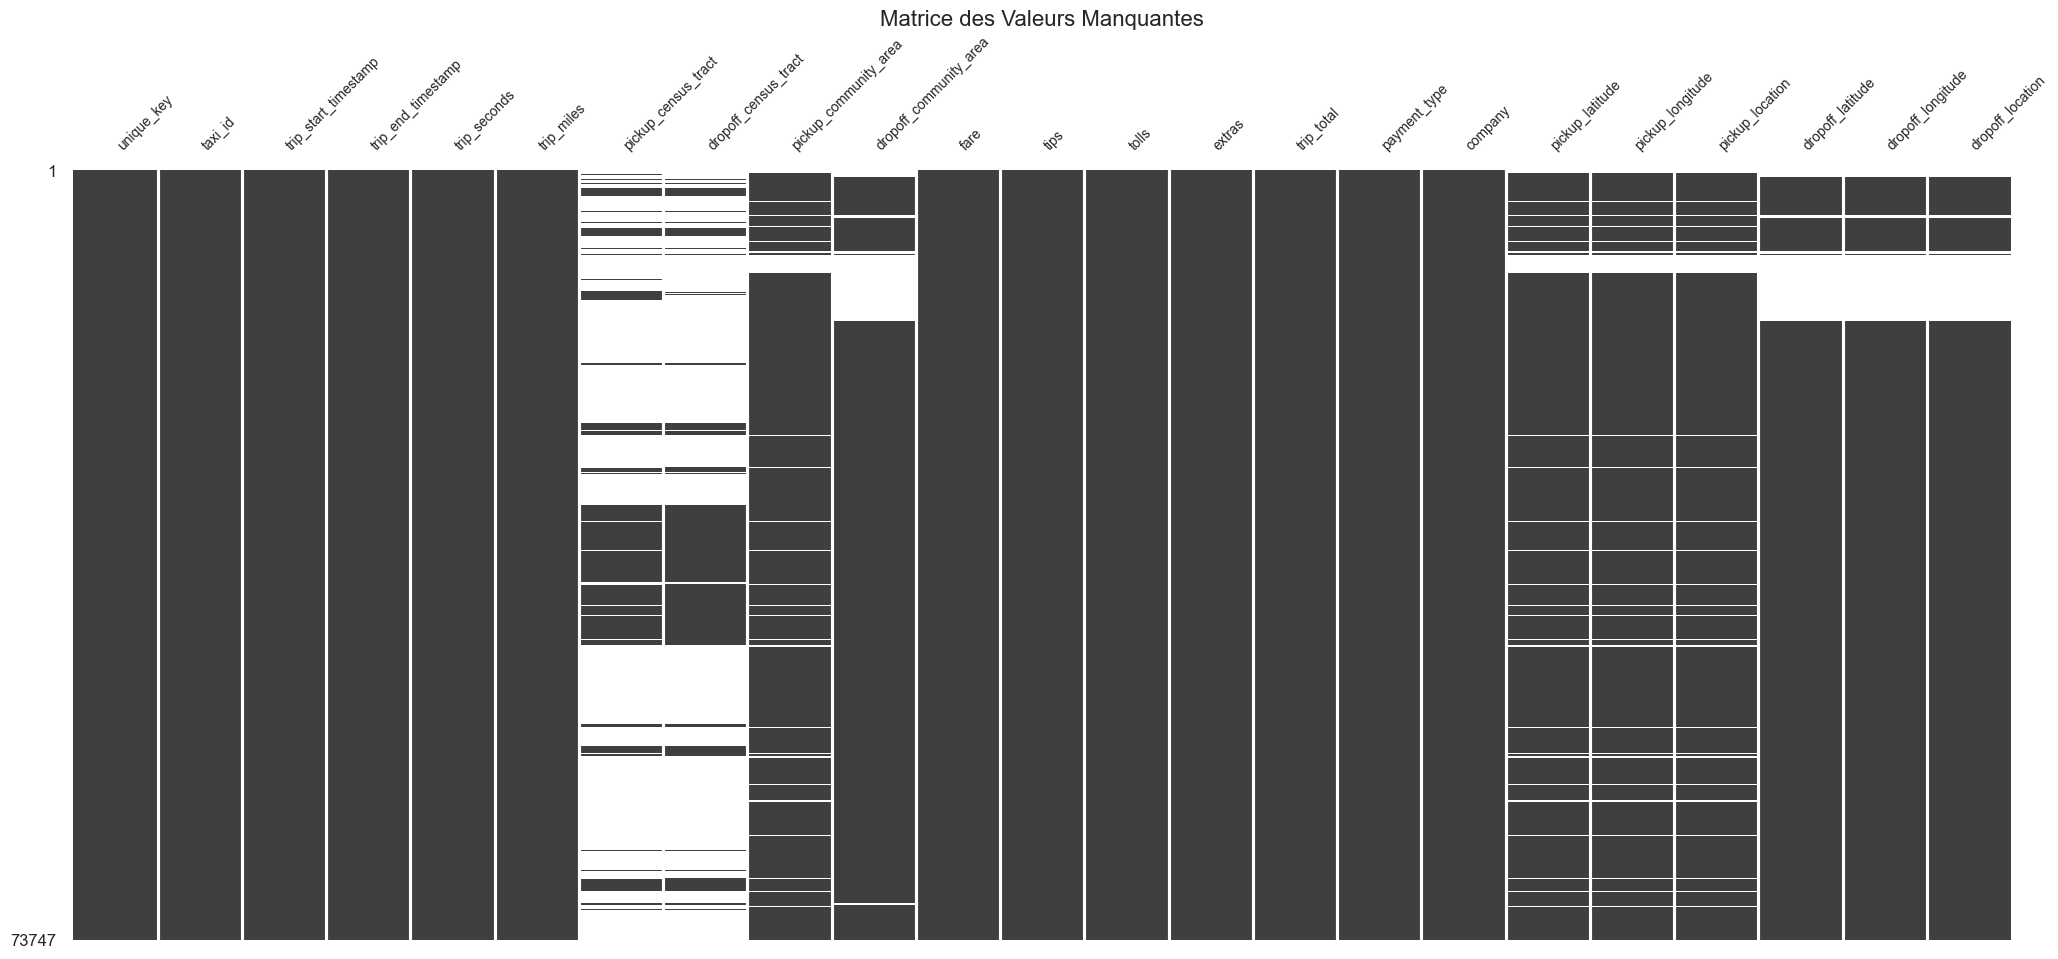

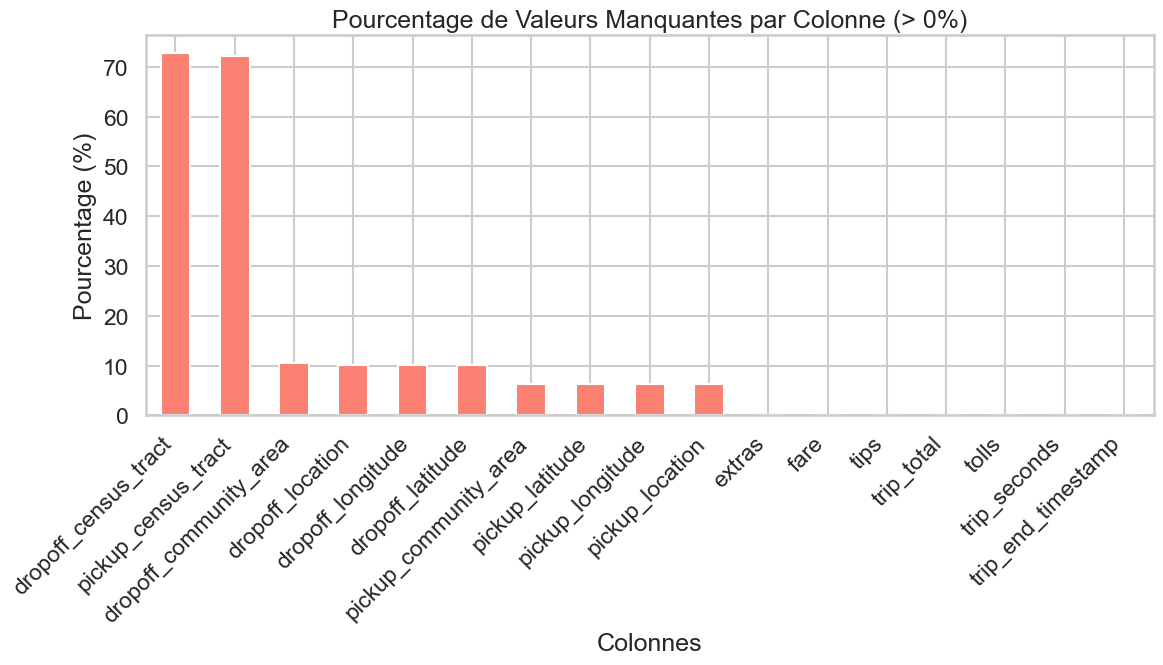

In [5]:
# Calcul et tri des pourcentages de valeurs manquantes
missing_pct = df_sample.isnull().sum() / len(df_sample) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
print("\nPourcentage de valeurs manquantes par colonne (> 0%):")
print(missing_pct)

# Visualisation du pattern des valeurs manquantes
plt.figure(figsize=(16, 8))
msno.matrix(df_sample.iloc[:, :40], sparkline=False, fontsize=10)
plt.title("Matrice des Valeurs Manquantes", fontsize=16)
plt.show()

# Visualisation par barre
if len(missing_pct) > 0:
    plt.figure(figsize=(12, 7))
    missing_pct.plot(kind='bar', color='salmon')
    plt.title("Pourcentage de Valeurs Manquantes par Colonne (> 0%)")
    plt.ylabel("Pourcentage (%)")
    plt.xlabel("Colonnes")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 2.4 Analyse des Tendances Temporelles

Analysons les patterns temporels des courses de taxi.

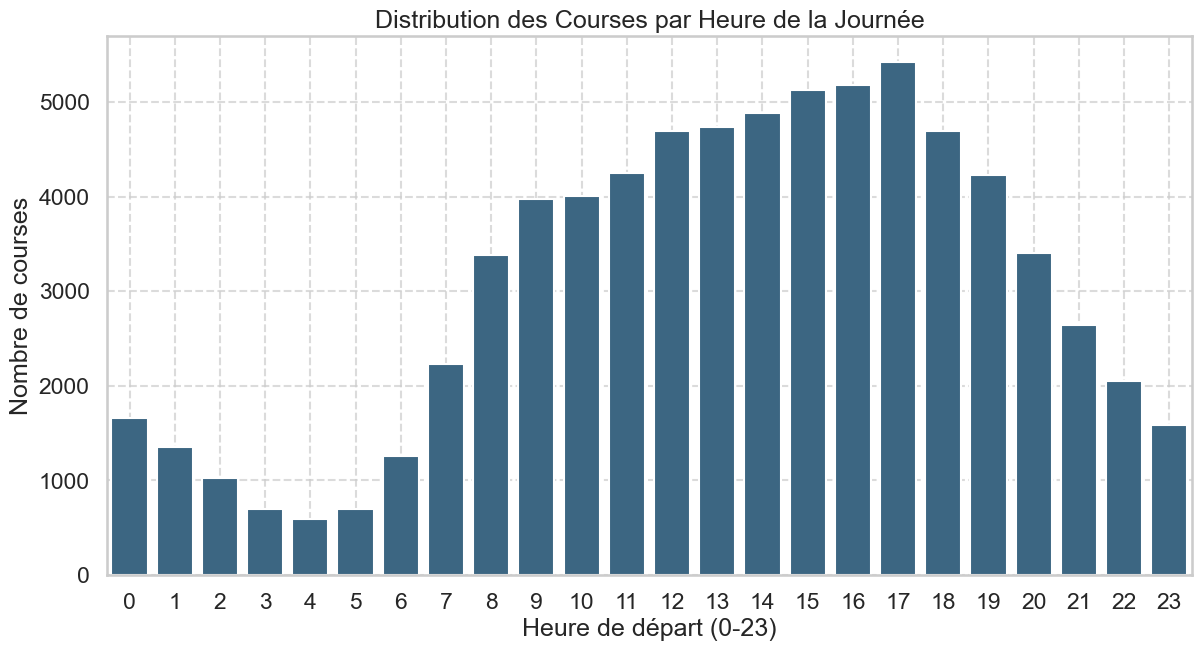

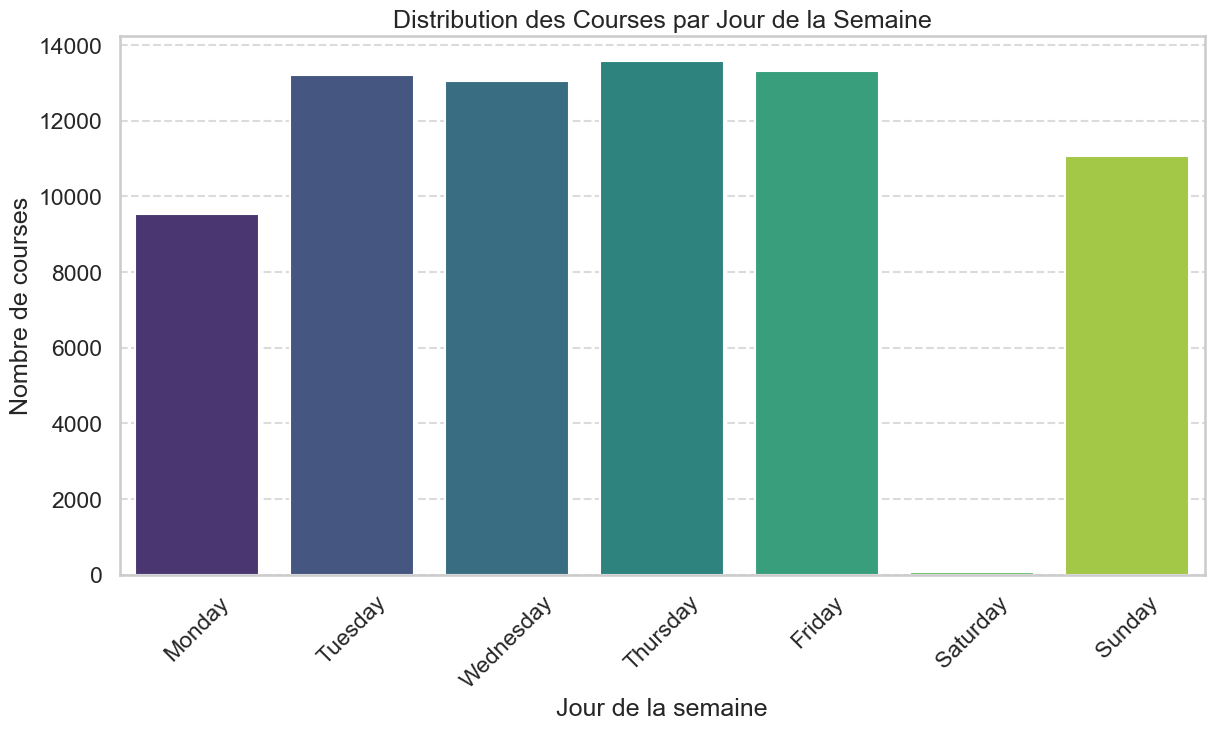

In [6]:
# Création de features temporelles
if 'trip_start_timestamp' in df_sample.columns:
    df_sample['start_hour'] = df_sample['trip_start_timestamp'].dt.hour
    df_sample['day_of_week'] = df_sample['trip_start_timestamp'].dt.dayofweek  # 0=Lundi, 6=Dimanche
    df_sample['day_name'] = df_sample['trip_start_timestamp'].dt.day_name()  # Nom du jour
    df_sample['month'] = df_sample['trip_start_timestamp'].dt.month
    df_sample['is_weekend'] = df_sample['day_of_week'].isin([5, 6]).astype(int)  # 1 si weekend, 0 sinon
    
    # Visualisation des tendances par heure
    plt.figure(figsize=(14, 7))
    hourly_count = df_sample.groupby('start_hour').size()
    sns.barplot(x=hourly_count.index, y=hourly_count.values, color=base_palette[2])
    plt.title("Distribution des Courses par Heure de la Journée")
    plt.xlabel("Heure de départ (0-23)")
    plt.ylabel("Nombre de courses")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # Visualisation des tendances par jour de la semaine
    plt.figure(figsize=(14, 7))
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    sns.countplot(data=df_sample, x='day_name', order=day_order, palette=sns.color_palette("viridis", 7))
    plt.title("Distribution des Courses par Jour de la Semaine")
    plt.xlabel("Jour de la semaine")
    plt.ylabel("Nombre de courses")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.show()

## 2.5 Analyse Spatiale

Examinons la distribution des courses par zone communautaire.

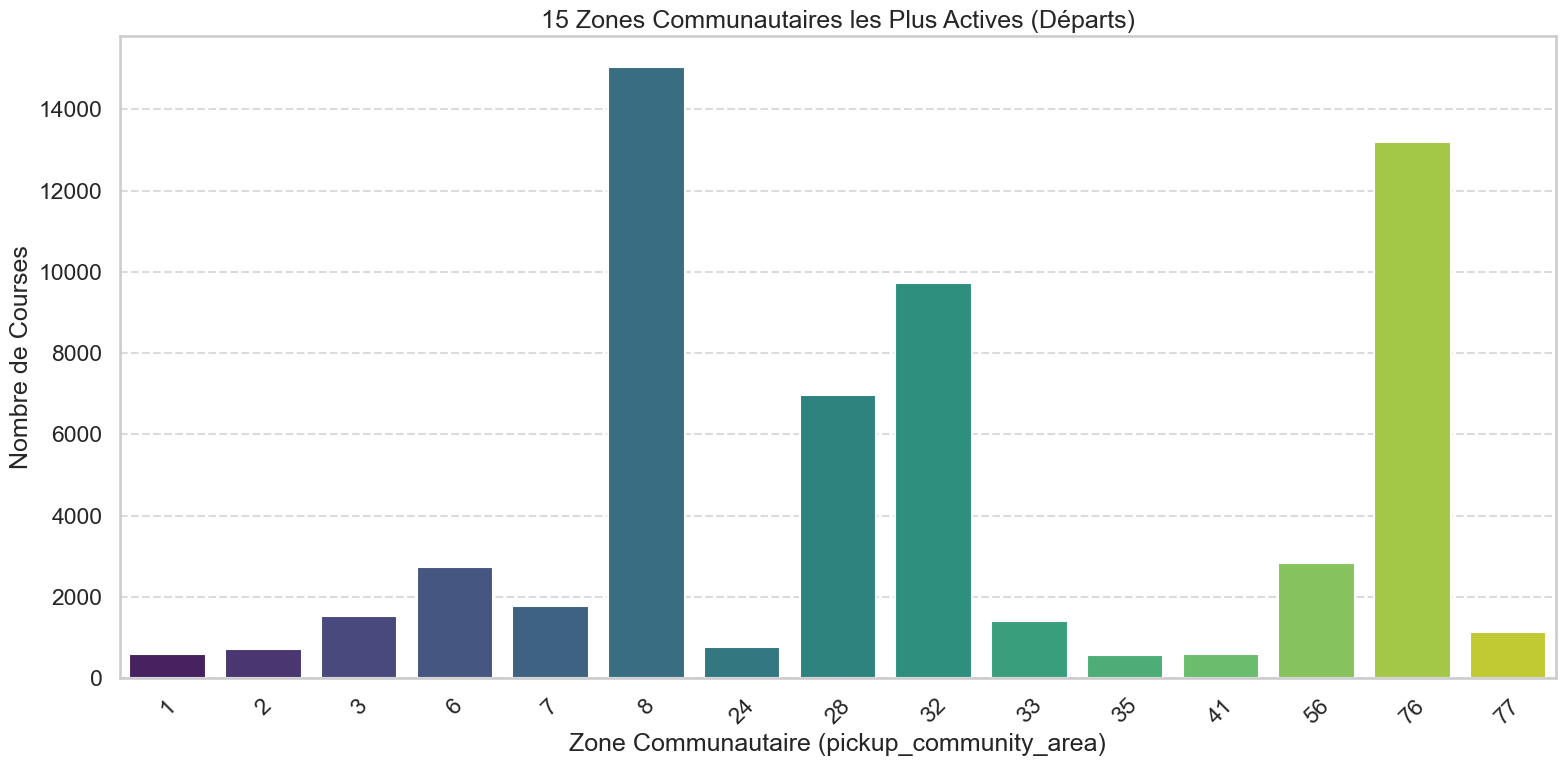

In [7]:
# Analyse des zones communautaires (pickup_community_area)
if 'pickup_community_area' in df_sample.columns:
    # Compter les courses par zone
    zone_counts = df_sample['pickup_community_area'].value_counts().reset_index()
    zone_counts.columns = ['pickup_community_area', 'count']
    zone_counts = zone_counts.sort_values('count', ascending=False)
    
    # Afficher les 15 principales zones
    plt.figure(figsize=(16, 8))
    sns.barplot(data=zone_counts.head(15), x='pickup_community_area', y='count', palette="viridis")
    plt.title("15 Zones Communautaires les Plus Actives (Départs)")
    plt.xlabel("Zone Communautaire (pickup_community_area)")
    plt.ylabel("Nombre de Courses")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()

# 3. Préparation des Données pour le Forecasting

Maintenant que nous avons exploré les données, préparons-les pour le forecasting en les agrégeant par heure et par zone.

## 3.1 Extraction des Données Complètes pour le Forecasting

Chargeons les données complètes avec les colonnes essentielles pour le forecasting.

In [8]:
# Requête SQL pour charger les données nécessaires au forecasting
forecasting_query = """
SELECT
  trip_start_timestamp,
  pickup_community_area
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE 
  pickup_community_area IS NOT NULL
  AND trip_start_timestamp >= '2022-01-01'
  AND trip_start_timestamp < '2023-01-01'
"""

print("Chargement des données depuis BigQuery... (peut prendre plusieurs minutes)")

# Option 1 : Charger via python - peut être lent pour de grands volumes
try:
    df_raw = read_gbq(forecasting_query, project_id=PROJECT_ID)
    print(f"✅ Dataset chargé avec succès. Nombre de lignes : {len(df_raw):,}")
except Exception as e:
    print(f"Erreur lors du chargement depuis BigQuery: {e}")
    print("⚠️ Nous allons passer à l'option 2: agrégation directe dans BigQuery")
    df_raw = None

# Option 2 (alternative) : Effectuer l'agrégation directement dans BigQuery
# Cette option est commentée car elle nécessite des privilèges d'écriture dans BigQuery
# Elle sera utilisée plus tard si nécessaire

Chargement des données depuis BigQuery... (peut prendre plusieurs minutes)
Downloading: 100%|██████████|
✅ Dataset chargé avec succès. Nombre de lignes : 5,478,642


## 3.2 Agrégation Temporelle par Heure et Zone

Agrégeons les données par heure et par zone communautaire pour créer la série temporelle.

In [9]:
if df_raw is not None:
    # Convertir les timestamps au format horaire (arrondi à l'heure)
    df_raw["timestamp_hour"] = pd.to_datetime(df_raw["trip_start_timestamp"]).dt.floor("H")
    
    # Agrégation : nombre de courses par heure et par pickup_community_area
    df_demand = (
        df_raw
        .groupby(["timestamp_hour", "pickup_community_area"])
        .size()
        .reset_index(name="trip_count")
        .sort_values(["timestamp_hour", "pickup_community_area"])
    )
    
    print(f"✅ Données agrégées : {len(df_demand):,} lignes.")
    df_demand.head()
else:
    print("⚠️ Pas de données brutes disponibles pour l'agrégation.")

✅ Données agrégées : 349,467 lignes.


## 3.3 Complétion des Séries Temporelles

Assurons-nous que toutes les combinaisons d'heures et de zones existent, même s'il n'y a pas de courses.

In [10]:
if 'df_demand' in locals() and not df_demand.empty:
    # Créer l'ensemble des heures disponibles dans le dataset (par pas de 1 heure)
    min_time = df_demand["timestamp_hour"].min()
    max_time = df_demand["timestamp_hour"].max()
    all_hours = pd.date_range(start=min_time, end=max_time, freq="H")
    
    # Identifier toutes les zones uniques
    all_zones = df_demand["pickup_community_area"].dropna().unique()
    all_zones = sorted(all_zones)
    
    # Créer le produit cartésien : toutes les combinaisons heure × zone
    complete_index = pd.MultiIndex.from_product(
        [all_hours, all_zones],
        names=["timestamp_hour", "pickup_community_area"]
    )
    
    # Créer un DataFrame complet
    df_complete = pd.DataFrame(index=complete_index).reset_index()
    
    # Fusionner avec les données observées
    df_demand_complete = pd.merge(
        df_complete,
        df_demand,
        on=["timestamp_hour", "pickup_community_area"],
        how="left"
    )
    
    # Remplacer les valeurs manquantes (heures sans courses) par 0
    df_demand_complete["trip_count"] = df_demand_complete["trip_count"].fillna(0).astype(int)
    
    print(f"✅ Séries temporelles complétées : {len(df_demand_complete):,} lignes.")
    df_demand_complete.head()
else:
    print("⚠️ Pas de données agrégées disponibles pour la complétion des séries temporelles.")

✅ Séries temporelles complétées : 674,520 lignes.


## 3.4 Ingénierie de Features Temporelles

Ajoutons des features temporelles utiles pour le forecasting.

In [11]:
if 'df_demand_complete' in locals() and not df_demand_complete.empty:
    # Extraire les features temporelles classiques
    df_demand_complete["hour"] = df_demand_complete["timestamp_hour"].dt.hour
    df_demand_complete["day_of_week"] = df_demand_complete["timestamp_hour"].dt.dayofweek  # Lundi = 0
    df_demand_complete["month"] = df_demand_complete["timestamp_hour"].dt.month
    df_demand_complete["day_of_year"] = df_demand_complete["timestamp_hour"].dt.dayofyear
    df_demand_complete["week_of_year"] = df_demand_complete["timestamp_hour"].dt.isocalendar().week.astype(int)
    df_demand_complete["year"] = df_demand_complete["timestamp_hour"].dt.year
    df_demand_complete["is_weekend"] = df_demand_complete["day_of_week"].isin([5, 6]).astype(int)
    
    # Encodage cyclique pour l'heure (utile pour certains modèles)
    df_demand_complete["hour_sin"] = np.sin(2 * np.pi * df_demand_complete["hour"] / 24)
    df_demand_complete["hour_cos"] = np.cos(2 * np.pi * df_demand_complete["hour"] / 24)
    
    print("✅ Features temporelles ajoutées.")
    # Aperçu
    df_demand_complete[["timestamp_hour", "pickup_community_area", "trip_count", "hour", "day_of_week", "month", "is_weekend"]].head()
else:
    print("⚠️ Pas de données disponibles pour l'ajout de features temporelles.")

✅ Features temporelles ajoutées.


## 3.5 Visualisation des Séries Temporelles

Visualisons les séries temporelles pour quelques zones principales.

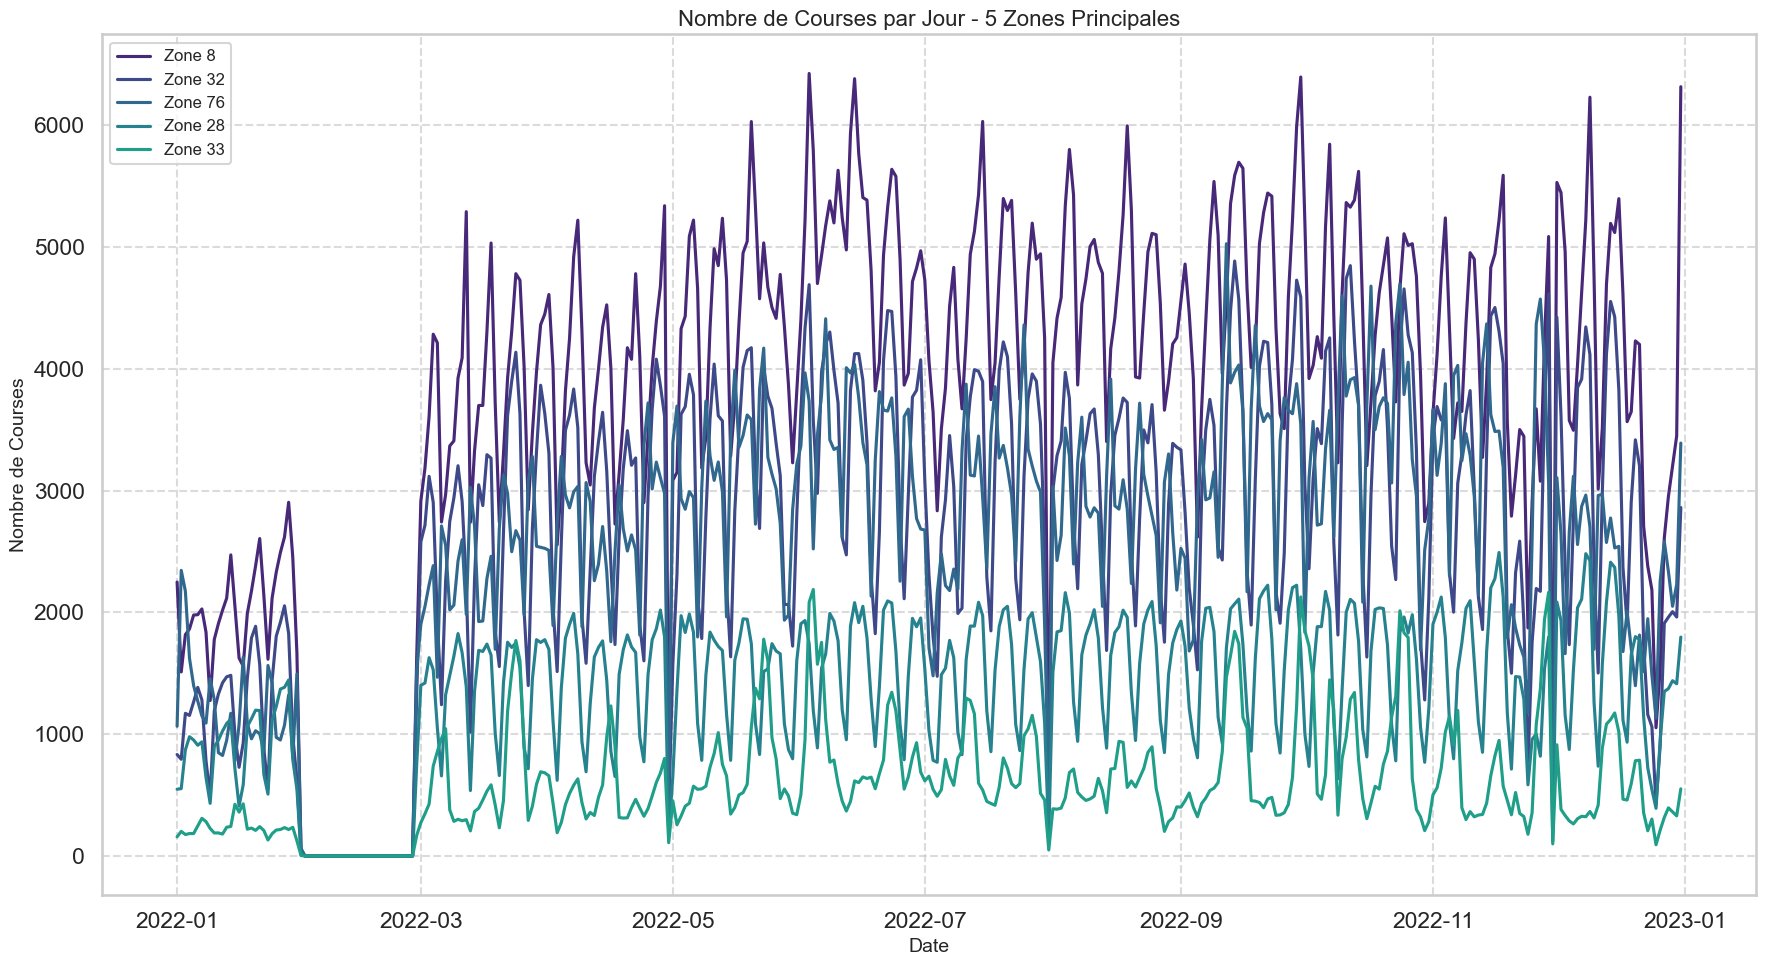

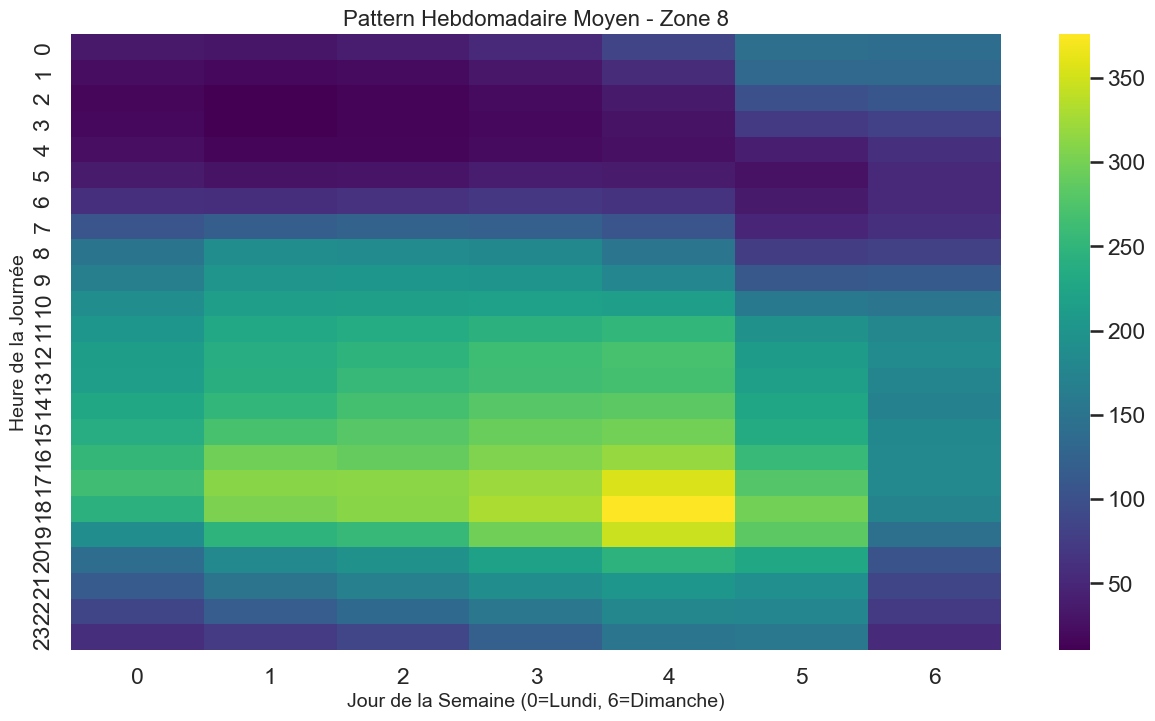

In [12]:
if 'df_demand_complete' in locals() and not df_demand_complete.empty:
    # Identifier les zones les plus actives
    top_active_zones = df_demand_complete.groupby('pickup_community_area')['trip_count'].sum().nlargest(5).index.tolist()
    
    # Filtrer pour ces zones
    df_top_zones = df_demand_complete[df_demand_complete['pickup_community_area'].isin(top_active_zones)]
    
    # Agréger par jour pour simplifier la visualisation
    df_top_zones['date'] = df_top_zones['timestamp_hour'].dt.date
    df_daily = df_top_zones.groupby(['date', 'pickup_community_area'])['trip_count'].sum().reset_index()
    
    # Visualiser les tendances pour les 5 zones principales
    plt.figure(figsize=(18, 10))
    for zone in top_active_zones:
        df_zone = df_daily[df_daily['pickup_community_area'] == zone]
        plt.plot(df_zone['date'], df_zone['trip_count'], label=f'Zone {zone}')
    
    plt.title('Nombre de Courses par Jour - 5 Zones Principales', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Nombre de Courses', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Visualisation hebdomadaire pour une zone spécifique
    # Sélectionner la zone la plus active
    top_zone = top_active_zones[0]
    
    # Analyse par jour de la semaine
    df_top_zone = df_demand_complete[df_demand_complete['pickup_community_area'] == top_zone]
    weekly_pattern = df_top_zone.groupby(['day_of_week', 'hour'])['trip_count'].mean().reset_index()
    weekly_pattern_pivot = weekly_pattern.pivot(index='hour', columns='day_of_week', values='trip_count')
    
    # Visualisation heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(weekly_pattern_pivot, cmap="viridis", annot=False, fmt=".1f")
    plt.title(f'Pattern Hebdomadaire Moyen - Zone {top_zone}', fontsize=16)
    plt.xlabel('Jour de la Semaine (0=Lundi, 6=Dimanche)', fontsize=14)
    plt.ylabel('Heure de la Journée', fontsize=14)
    plt.show()
else:
    print("⚠️ Pas de données disponibles pour la visualisation des séries temporelles.")

## 3.6 Export vers BigQuery pour Vertex AI Forecast

Exportons les données préparées vers BigQuery pour l'utilisation avec Vertex AI Forecast.

In [13]:
if 'df_demand_complete' in locals() and not df_demand_complete.empty:
    # Alternative: si les données sont trop volumineuses, utiliser la requête SQL suivante directement dans BigQuery
    # (cette requête effectue la même transformation que les étapes précédentes)
    bq_query = """
    CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.demand_by_hour` AS
    WITH 
      hours AS (
        SELECT 
          MIN(TIMESTAMP_TRUNC(trip_start_timestamp, HOUR)) AS min_hour,
          MAX(TIMESTAMP_TRUNC(trip_start_timestamp, HOUR)) AS max_hour
        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE 
          trip_start_timestamp >= '2022-01-01' 
          AND trip_start_timestamp < '2023-01-01'
      ),
      all_hours AS (
        SELECT timestamp_hour
        FROM hours,
        UNNEST(GENERATE_TIMESTAMP_ARRAY(min_hour, max_hour, INTERVAL 1 HOUR)) AS timestamp_hour
      ),
      areas AS (
        SELECT DISTINCT pickup_community_area
        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE pickup_community_area IS NOT NULL
      ),
      all_combinations AS (
        SELECT
          h.timestamp_hour,
          a.pickup_community_area
        FROM all_hours h
        CROSS JOIN areas a
      ),
      aggregated AS (
        SELECT
          TIMESTAMP_TRUNC(trip_start_timestamp, HOUR) AS timestamp_hour,
          pickup_community_area,
          COUNT(*) AS trip_count
        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE 
          pickup_community_area IS NOT NULL
          AND trip_start_timestamp >= '2022-01-01' 
          AND trip_start_timestamp < '2023-01-01'
        GROUP BY 1, 2
      ),
      filled AS (
        SELECT
          ac.timestamp_hour,
          ac.pickup_community_area,
          IFNULL(agg.trip_count, 0) AS trip_count
        FROM all_combinations ac
        LEFT JOIN aggregated agg
          ON ac.timestamp_hour = agg.timestamp_hour
         AND ac.pickup_community_area = agg.pickup_community_area
      )
    SELECT
      timestamp_hour,
      pickup_community_area,
      trip_count,
      EXTRACT(HOUR FROM timestamp_hour) AS hour,
      EXTRACT(DAYOFWEEK FROM timestamp_hour) AS day_of_week,
      EXTRACT(MONTH FROM timestamp_hour) AS month,
      EXTRACT(YEAR FROM timestamp_hour) AS year,
      EXTRACT(DAYOFYEAR FROM timestamp_hour) AS day_of_year,
      IF(EXTRACT(DAYOFWEEK FROM timestamp_hour) IN (1, 7), 1, 0) AS is_weekend
    FROM filled
    ORDER BY timestamp_hour, pickup_community_area;
    """.format(PROJECT_ID=PROJECT_ID, BQ_DATASET=BQ_DATASET)
    
    # Exécuter la requête BigQuery
    print("Exécution de la requête d'agrégation directement dans BigQuery...")
    try:
        job = client.query(bq_query)
        job.result()  # Attendre la fin du job
        print(f"✅ Table exportée vers BigQuery : {PROJECT_ID}.{BQ_DATASET}.demand_by_hour")
    except Exception as e:
        print(f"⚠️ Erreur lors de l'exécution de la requête BigQuery : {e}")
        
        # Option alternative: exporter depuis pandas si la requête SQL échoue
        try:
            print("Tentative d'export depuis pandas...")
            # Sélectionner les colonnes pertinentes
            columns_to_keep = [
                "timestamp_hour", "pickup_community_area", "trip_count",
                "hour", "day_of_week", "month", "year", "day_of_year", "is_weekend"
            ]
            
            # Filtrer les colonnes
            df_to_export = df_demand_complete[columns_to_keep]
            
            # Configurer le job
            job_config = bigquery.LoadJobConfig(
                write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
            )
            
            # Exporter
            table_id = f"{PROJECT_ID}.{BQ_DATASET}.demand_by_hour"
            job = client.load_table_from_dataframe(
                df_to_export, table_id, job_config=job_config
            )
            job.result()  # Attendre la fin du job
            print(f"✅ Table exportée vers BigQuery via pandas : {table_id}")
        except Exception as e2:
            print(f"⚠️ Échec de l'export via pandas : {e2}")
else:
    # Si nous n'avons pas pu charger les données en mémoire, exécuter directement la requête
    print("Pas de données en mémoire, exécution de la requête d'agrégation directement dans BigQuery...")
    # (Code de la requête BigQuery identique à celui ci-dessus)

Exécution de la requête d'agrégation directement dans BigQuery...
⚠️ Erreur lors de l'exécution de la requête BigQuery : 404 Not found: Dataset avisia-certification-ml-yde:chicago_taxis was not found in location US; reason: notFound, message: Not found: Dataset avisia-certification-ml-yde:chicago_taxis was not found in location US

Location: US
Job ID: e617691d-064c-43ea-9fe0-bbedcff3b7b4

Tentative d'export depuis pandas...
✅ Table exportée vers BigQuery via pandas : avisia-certification-ml-yde.chicago_taxis.demand_by_hour


# 4. Conclusion et Prochaines Étapes

## Résumé de l'Analyse
- Nous avons exploré le dataset Chicago Taxi Trips et identifié des patterns temporels importants.
- Les données ont été agrégées par heure et par zone communautaire (pickup_community_area).
- Nous avons créé des features temporelles utiles pour le forecasting.
- Les données préparées ont été exportées vers BigQuery pour une utilisation avec Vertex AI Forecast.

## Prochaines Étapes
- Utiliser Vertex AI Forecast pour entraîner un modèle de prévision (dans le notebook suivant).
- Évaluer la performance du modèle.
- Générer des prédictions pour les périodes futures.
- Visualiser les résultats de prévision pour aider à la prise de décision.